# Сопровождение спутников #

## Прототип генератора траекторий для идентификации параметров модели sgp4 ##

Данные спутников взяты с сайта https://celestrak.com/

Формат данных - [TLE](https://ru.wikipedia.org/wiki/TLE)

В нём закодированы элементы орбиты тела для модели [SGP4](https://pypi.org/project/sgp4/)

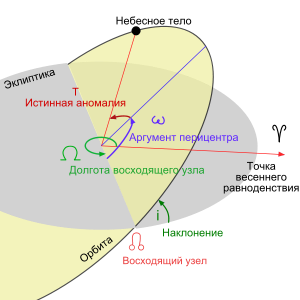

### Важные параметры (подлежат идентификации) ###
* Первая строка:
    * 9 34-43 **ndot** Первая производная от среднего движения (ускорение), делённая на два \[виток/день^2\] **(игнорируется sgp4)**
    * 10 45-52 **nddot** Вторая производная от среднего движения, делённая на шесть (подразумевается, что число начинается с десятичного разделителя) \[виток/день^3\] **(игнорируется sgp4)**
    * 11 54-61 **bstar** Коэффициент торможения B* (подразумевается, что число начинается с десятичного разделителя)
* Вторая строка:
    * 3 09-16 **inclo** [Наклонение](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%BA%D0%BB%D0%BE%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D1%80%D0%B1%D0%B8%D1%82%D1%8B) в градусах **(У Satrec - в радианах)**
    * 4 18-25 **nodeo** [Долгота восходящего узла](https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%BB%D0%B3%D0%BE%D1%82%D0%B0_%D0%B2%D0%BE%D1%81%D1%85%D0%BE%D0%B4%D1%8F%D1%89%D0%B5%D0%B3%D0%BE_%D1%83%D0%B7%D0%BB%D0%B0) в градусах **(У Satrec - в радианах)**
    * 5 27-33 **ecco** [Эксцентриситет](https://ru.wikipedia.org/wiki/%D0%AD%D0%BA%D1%81%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B8%D1%81%D0%B8%D1%82%D0%B5%D1%82) (подразумевается, что число начинается с десятичного разделителя)
    * 6 35-42 **argpo** [Аргумент перицентра](https://ru.wikipedia.org/wiki/%D0%90%D1%80%D0%B3%D1%83%D0%BC%D0%B5%D0%BD%D1%82_%D0%BF%D0%B5%D1%80%D0%B8%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0) в градусах **(У Satrec - в радианах)**
    * 7 44-51 **mo** [Средняя аномалия](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D1%8F) в градусах **(У Satrec - в радианах)**
    * 8 53-63 **no_kozai** Частота обращения (оборотов в день) (среднее движение) \[виток/день\] **(У Satrec - в радианах в минуту)**


In [1]:
import os
import sys
from datetime import datetime
from math import floor, log10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sgp4.api import Satrec
from sgp4.api import SatrecArray
from sgp4.api import jday
from sgp4.ext import days2mdhms
from sgp4.io import compute_checksum
from sgp4.api import SGP4_ERRORS
from scipy.optimize import minimize
import julian
import pickle
from orbital.constants import earth_mu
from orbital.utilities import elements_from_state_vector, mean_anomaly_from_true
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints, JulierSigmaPoints

print(SGP4_ERRORS)

{1: 'mean eccentricity is outside the range 0.0 to 1.0', 2: 'nm is less than zero', 3: 'perturbed eccentricity is outside the range 0.0 to 1.0', 4: 'semilatus rectum is less than zero', 5: '(error 5 no longer in use; it meant the satellite was underground)', 6: 'mrt is less than 1.0 which indicates the satellite has decayed'}


In [2]:
#See https://space.stackexchange.com/questions/1904/how-to-programmatically-calculate-orbital-elements-using-position-velocity-vecto
from orbital.constants import earth_mu
from orbital.utilities import elements_from_state_vector, mean_anomaly_from_true
print(earth_mu)
def initial_estimate(__r, __v):
    #Считаем базисный вектор плоскости орбиты
    _r = __r.copy() * 1000
    _v = __v.copy() * 1000
    #Так удобнее считать
    rt = _r.T.copy()
    rn = np.linalg.norm(rt, axis=0)
    
    vt = _v.T.copy()
    vn = np.linalg.norm(vt, axis=0)
    
    # h = r x v
    h = np.cross(_r, _v).T
    hn  = np.linalg.norm(h, axis=0)
    
    # n = k x h
    n = np.zeros(h.shape, dtype = np.float)
    n[0] = -h[1]
    n[1] =  h[0]
    nn = np.linalg.norm(n, axis=0)
    
    # Базисные вектора (плоскость орбиты - ij, k - нормаль)
    dk = h/hn # Направление h
    di = n/nn # Направление на восходящий узел
    dj = np.cross(dk, di, axis=0)
    
    # Склонение орбиты
    inclo = np.arccos(np.mean(dk[2]))
    
    # Вектор эксцентриситета
    # e = (v x h)/mu - r/nr
    e = np.cross(vt, h, axis=0)/earth_mu - rt/rn
    
    # Скалярное произведение пакетов векторов
    def batch_dot(a, b):
        return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]
    
    # Вектор "возмущений", не равен нулю у возмущенных орбит
    ek = batch_dot(e, dk)
    
    # Восстанавливаем "невозмущенный" вектор эксцентриситета
    e[2] -= ek
    en = np.linalg.norm(e, axis=0)
    
    # Эксцентриситет
    ecco = np.mean(en)
    
    # Специальная механическая энергия
    # E = vn**2/2 - mu/rn
    E = vn*vn*.5 - earth_mu/rn
    
    # Т.к. у нас спутники, то можно не заморачиваться по параболическим и 
    # гиперболическим орбитам
    a = - earth_mu/2./E
    
    # Средняя угловая скорость
    no_kozai = np.mean(np.sqrt(earth_mu / (a*a*a))) * 60 #Согласовываем с sgp4
    
    
    oe = elements_from_state_vector(_r[0], _v[0], earth_mu)
    
    # Средняя аномалия
    # Перевод в среднюю аномалию
    # Если что - смотерть тут https://github.com/RazerM/orbital/blob/0.7.0/orbital/utilities.py#L115
    # и тут https://en.wikipedia.org/wiki/Eccentric_anomaly#From_the_true_anomaly
    #print(oe.f)
    #print(oe.e)
    mo = mean_anomaly_from_true(oe.e, oe.f)
    
    #                inclo   nodeo   ecco    argpo    mo  no_kozai
    return 0.,0.,0., inclo, oe.raan, ecco, oe.arg_pe, mo, no_kozai

d2r   = np.pi/180.     # Градусы в радианы
mpd   = 1440.          # Количество минут в сутках
xd2rm = mpd/(2.*np.pi) # Об./сут. -> рад./мин.

from math import fabs, fmod

def estimate_transform(ndot, nddot, bstar, inclo, nodeo, ecco, argpo, mo, no_kozai):
    
    ab = fabs(bstar)
    if ab >= 1:
        if ab > 0:
            bstar = .99999
        else:
            bstar = -.99999
    
    inclo = fmod(inclo, np.pi)
    if inclo < 0.:
        inclo = -inclo

    nodeo = fmod(nodeo, 2.*np.pi)
    if nodeo < 0.:
        nodeo = 2.*np.pi - nodeo
    
    if ecco >= .999999:
        ecco = .999999
        
    if ecco < 0.:
        ecco = 0.
        
    argpo = fmod(argpo, 2.*np.pi)
    if argpo < 0.:
        argpo = 2.*np.pi - argpo
    
    mo = fmod(mo, 2.*np.pi)
    if mo < 0.:
        mo = 2.*np.pi - mo
    
    if no_kozai < 0.:
        no_kozai = 0.
        
    if no_kozai > .1:
        no_kozai = .1
    
    return ndot*xd2rm*mpd, nddot*xd2rm*mpd*mpd, bstar, inclo/d2r, nodeo/d2r, ecco, argpo/d2r, mo/d2r, no_kozai*xd2rm

def fake_tle(epoch, ndot, nddot, bstar, inclo, nodeo, ecco, argpo, mo, no_kozai):
    #TODO: Check args
    #==========================================================================
    # year
    dt = julian.from_jd(epoch, fmt='jd')
    y = dt.year - 2000
    yjd = sum(jday(dt.year, 1, 1, 0, 0, 0))
    #==========================================================================
    # days
    days = epoch - yjd + 1
    eday = int(days)
    etime = round((days - eday) * 100000000)
    #==========================================================================
    # ndot
    nds = '-' if ndot < 0 else ' '
    ndf = round(abs(ndot)*100000000)
    #==========================================================================
    # nddot
    def fldecomp(s):
        ss = '-' if s < 0 else ' '
        s = abs(s)
        #
        def fexp(f):
            return int(floor(log10(abs(f)))) if f != 0 else 0
        #
        se = abs(fexp(s) + 1)
        sh = 0
        if se > 9:
            sh = se - 9
            se = 9
        #
        def fman(f):
            return f/10**(fexp(f) + sh)
        #
        if sh > 4:
            sm = 0
        else:
            sm = round(fman(s)*10000)
        #
        if sm == 0:
            se = 0
        #
        return ss, sm, se
    #
    ndds, nddm, ndde = fldecomp(nddot)
    #==========================================================================
    # bstar
    #TODO: Ексепшон при bstar>1
    bss, bsm, bse = fldecomp(bstar)
    #==========================================================================
    # inclo
    def dec_angle(a):
        ai = int(a)
        af = round((a - ai) * 10000)
        return ai, af
    #
    i_i, i_f = dec_angle(inclo)
    #==========================================================================
    # nodeo
    n_i, n_f = dec_angle(nodeo)
    #==========================================================================
    # ecco
    ecco = round(ecco * 10000000)    
    #==========================================================================
    # argpo
    p_i, p_f = dec_angle(argpo)
    #==========================================================================
    # mo
    m_i, m_f = dec_angle(mo)
    #==========================================================================
    # no_kozai
    nki = int(no_kozai)
    nkf = round((no_kozai - nki)*100000000)
    #==========================================================================
    # L1
    #'1 99999U 99999A   YYDDD.TTTTTTTT S.dddddddd  Nddot-N  BBBBB-b 0 VVVVC'
    l1 = '1 99999U 99999A   %02d%03d.%08d %c.%08d %c%05d-%1d %c%05d-%1d 0  999'
    l1 = l1 % (y, eday, etime, nds, ndf, ndds, nddm, ndde, bss, bsm, bse)
    l1 += str(compute_checksum(l1))
    #==========================================================================
    # L2
    #'2 99999 III.iiii WWW.wwww eeeeeee www.WWWW AAA.aaaa FF.ffffffffNNNNNC'
    l2 = '2 99999 %3d.%04d %3d.%04d %07d %3d.%04d %3d.%04d %2d.%08d 9999'
    l2 = l2 % (i_i, i_f, n_i, n_f, ecco, p_i, p_f, m_i, m_f, nki, nkf)
    l2 += str(compute_checksum(l2))
    return l1,l2

def get_sat_epoch(y, d):
    y += 2000
    return sum(jday(y, *days2mdhms(y, d)))

def get_tle_data(_r,_v):
    kep = elements_from_state_vector(np.array(_r)*1000, np.array(_v)*1000, earth_mu)
    mo = mean_anomaly_from_true(kep.e, kep.f)
    a = kep.a
    no_kozai = np.sqrt(earth_mu / (a*a*a)) * 60
    return np.array((kep.i, kep.raan, kep.e, kep.arg_pe, mo, no_kozai))

def eval_tle(x, _epoch, _bstar):
    try:
        # Генерируем спутник
        ysat_vals = estimate_transform(0, 0, _bstar, *tuple(x))
        ysat = Satrec.twoline2rv(*fake_tle(_epoch, *ysat_vals))
    
        # Моделируем его сотояние на момент "Эпохи"
        yfr, yjd = np.modf(_epoch)
        ye,yr,yv = ysat.sgp4(yjd, yfr)
    except Exception as ex:
        print(ex)
        ye = 5
    
    if ye != 0:
        return np.zeros(x.shape, dtype=np.float), ye
    
    # Возвращаем наблюдаемые значения элементов движения
    return get_tle_data(yr,yv), 0

# Подгонка модели 
def fit_sgp4_bstar_fixed(__r, __v, __epoch, __bstar=0, g0 = .1, eps=.7, stop_thr=1e-10, max_iter=1000):
    #Наблюдаемые значения
    yo = get_tle_data(__r,__v)

    #Начальное приближение
    x = yo.copy()

    # Коэффициенты усиления ошибок
    gains = np.ones(x.shape, dtype=np.float) * g0

    # Информация о знаках невязок
    sez = yo >= x
    
    exc = 0

    for j in range(max_iter):
        # Невязки
        y, exc = eval_tle(x, __epoch, __bstar)
        if (exc):
            break
        e = yo - y
    
        #Особенности работы с углами
        # nodeo, argpo, mo
        for i in (1,3,4):
            if e[i] > np.pi:
                e[i] -= 2*np.pi
            
            if e[i] < -np.pi:
                e[i] += 2*np.pi
    
        #Знаки невязок
        se = e > 0.
        changed = np.logical_xor(se, sez)
        sez = se
    
        # Если знак не менялся - увеличиваем коэффициент, 
        # если менялся - уменьшаем
        gains *= (1. + eps)*np.logical_not(changed) + (1. + eps)*changed
        gains = np.clip(gains, 0., 1.)
    
        dx = gains * e
        # Ограничения:
        # inclo[0, pi] ecco [0;.9999999], no_kozai [0; 0.1]
        for i,ul in ((0, np.pi),(2, .9999999),(5, 0.1)):
            
            if dx[i] == 0:
                continue
            
            k = 1
            
            if x[i] + dx[i] >= ul:
                k = (ul - x[i])/(2. * dx[i])
                
            if x[i] + dx[i] <= 0:
                k = np.abs(x[i]/(2. * dx[i]))
            
            gains[i] /= k
            dx[i]    /= k
        
        if np.max(dx)/(2.*np.pi) < stop_thr:
            break
    
        x += dx
        # Нормализация углов
        for i in (1,3,4):
            x[i] = fmod(x[i], 2.*np.pi)
            if x[i] < 0.:
                x[i] = 2.*np.pi - x[i]

    return x, j, exc

398600441500000.0


In [3]:
# Грузим TLE реальных спутников
CELESTRACK = 'data/celestrak'

tle_data = []

for fname in os.listdir(CELESTRACK):
    with open(CELESTRACK + '/' + fname) as f:
        for l in f.readlines():
            tle_data.append(l.split('\n')[0].split('\r')[0])
        
print(len(tle_data)/3.)

9923.0


In [4]:
#Формируем массиввы данных для генератора орбит
tle_hd = [] #Header
tle_l1 = [] #Line 1
tle_l2 = [] #Line 2

for i in range(len(tle_data)//3):
    tle_hd.append(tle_data[3 * i + 0])
    tle_l1.append(tle_data[3 * i + 1])
    tle_l2.append(tle_data[3 * i + 2])
    
#Проверки TLE
for l in tle_l1:
    if l[0] != '1':
        print('1. Fuck!!!')
        
for l in tle_l2:
    if l[0] != '2':
        print('2. Fuck!!!')
        
for i in range(len(tle_l1)):
    if tle_l1[i][2:7] != tle_l2[i][2:7]:
        print('3. FUCK!')

In [5]:
#Формируем массив моделей sgp4
sat = [] #Sattelite model
sat_num = []
sat_tle_l1 = []
sat_tle_l2 = []
sat_jd = []
sat_fr = []
sat_r = []
sat_v = []
for i in range(len(tle_hd)):
    s = Satrec.twoline2rv(tle_l1[i], tle_l2[i])
    # Только уникальные спутники
    if s.satnum not in sat_num:
        # Верификация спутника, он должен месяц продержаться на орбите
        delta = float(2. * np.pi / (s.no_kozai * 1440.))/50 #50 точек на период
        epoch = get_sat_epoch(s.epochyr, s.epochdays)       #Начало эпохи
        # Юлианские дата/время для каждой точки
        fr, jd = np.modf(np.array([epoch + delta*k for k in range(int(31./delta) + 1)]))
        # Получаем траекторию
        e, r, v = s.sgp4_array(jd, fr)
        if np.sum(e) == 0:
            sat_num.append(s.satnum)
            sat.append(s)
            sat_tle_l1.append(tle_l1[i])
            sat_tle_l2.append(tle_l2[i])
            sat_r.append(r)
            sat_v.append(v)
            sat_jd.append(jd)
            sat_fr.append(fr)

print(len(sat))

7341


In [6]:
# Формируем массив y (Параметры спутников)
sat_col = ['satnum', 'epochyr', 'epochdays', 'ndot', 'nddot', 'bstar', 'inclo', 'nodeo', 'ecco', 'argpo', 'mo', 'no_kozai']

sat_data = np.zeros((len(sat), len(sat_col)), dtype=np.float)

for i,s in enumerate(sat):
    for j,c in enumerate(sat_col):
        sat_data[i,j] = getattr(s, c)
    

sat_df = pd.DataFrame(sat_data, columns=sat_col)
sat_df['satnum'] = sat_df['satnum'].astype(np.int64)
sat_df['epochyr'] = sat_df['epochyr'].astype(np.int64)
sat_df['tle1'] = sat_tle_l1
sat_df['tle2'] = sat_tle_l2

sat_df.to_csv('data/satrec.csv')
sat_df.describe()

,satnum,epochyr,epochdays,ndot,nddot,bstar,inclo,nodeo,ecco,argpo,mo,no_kozai
count,7341.000000,7341.0,7341.000000,7.341000e+03,7.341000e+03,7341.000000,7341.000000,7341.000000,7341.000000,7341.000000,7341.000000,7341.000000
mean,38294.182264,20.0,34.339999,1.332155e-10,1.340653e-16,0.000512,1.376920,2.856406,0.020838,3.054458,3.183489,0.055817
std,13950.724154,0.0,1.490124,1.029326e-09,3.637532e-15,0.018760,0.510497,1.745313,0.087840,1.829143,1.829473,0.018789
min,694.000000,20.0,5.694564,-4.634637e-09,-1.241472e-14,-0.720710,0.000016,0.000108,0.000004,0.001189,0.000925,0.001246
25%,31199.000000,20.0,34.001667,1.515043e-12,0.000000e+00,0.000020,1.290589,1.438431,0.001089,1.437799,1.537488,0.060684
50%,35605.000000,20.0,34.706359,1.002958e-11,0.000000e+00,0.000087,1.699610,2.451507,0.004223,3.031173,3.249943,0.062418
75%,41826.000000,20.0,35.048440,2.869491e-11,0.000000e+00,0.000272,1.725043,4.431241,0.011837,4.692513,4.789028,0.064296
max,89496.000000,20.0,38.192268,2.474595e-08,2.147152e-13,0.999990,2.356360,6.282634,0.891269,6.282927,6.283056,0.070067


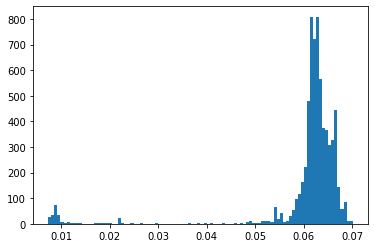

In [7]:
_ = plt.hist(sat_df[sat_df['no_kozai'] > .006]['no_kozai'], bins=100)

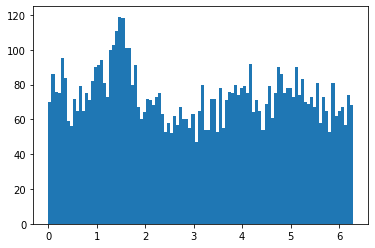

In [8]:
_ = plt.hist(sat_df['argpo'], bins=100)

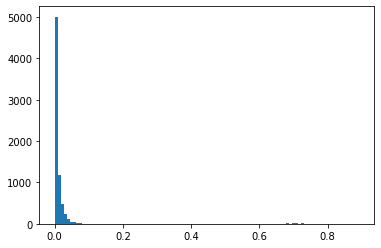

In [9]:
_ = plt.hist(sat_df['ecco'], bins=100)

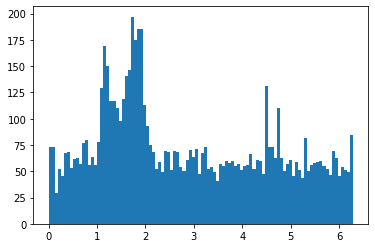

In [10]:
_ = plt.hist(sat_df['nodeo'], bins=100)

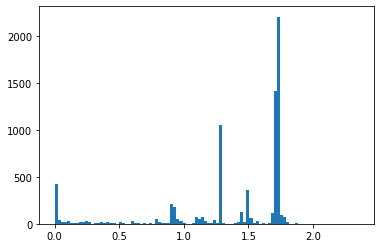

In [11]:
_ = plt.hist(sat_df['inclo'], bins=100)

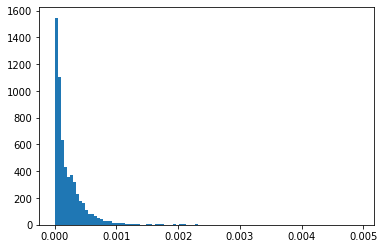

In [12]:
_ = plt.hist(sat_df[(sat_df['bstar'] < .005) & (sat_df['bstar'] > .0)]['bstar'], bins=100)

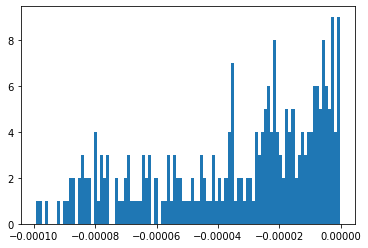

In [13]:
_ = plt.hist(sat_df[(sat_df['bstar'] < 0.) & (sat_df['bstar'] > -.0001)]['bstar'], bins=100)

In [219]:
#i = sat_df[sat_df['no_kozai'] == np.max(sat_df['no_kozai'])].index[0]
#i = sat_df[sat_df['no_kozai'] == np.min(sat_df['no_kozai'])].index[0]
#i = sat_df[sat_df.bstar == np.max(sat_df.bstar)].index[0]
#i = sat_df[sat_df.bstar == np.min(sat_df.bstar)].index[0]
#i = 7000
#i = 3547
#i = 2573
#i = 1572
#i = 2235
#i = 4321
i = sat_df[sat_df.satnum == 44249].index[0]
#i = np.random.randint(0, len(sat_df))
print(sat_df.iloc[i])

satnum                                                   44249
epochyr                                                     20
epochdays                                              34.9167
ndot                                               6.48466e-09
nddot                                                        0
bstar                                                 0.010093
inclo                                                 0.924977
nodeo                                                  1.62468
ecco                                                 0.0006819
argpo                                                  5.67763
mo                                                     3.90999
no_kozai                                             0.0662371
tle1         1 44249U 19029Q   20034.91667824  .00214009  0...
tle2         2 44249  52.9973  93.0874 0006819 325.3043 224...
Name: 2774, dtype: object


In [220]:
# Предварительные условия
xsat = sat_df.iloc[i]

xsat_true = xsat[['ndot', 'nddot', 'bstar', 'inclo', 'nodeo', 'ecco', 'argpo', 'mo', 'no_kozai']].values
xsat_epoch = get_sat_epoch(xsat.epochyr, xsat.epochdays)

xsat_vals = estimate_transform(*tuple(xsat_true))
xsat_mdl = Satrec.twoline2rv(*fake_tle(xsat_epoch, *xsat_vals))

fr, jd = np.modf(xsat_epoch)
e,r,v = xsat_mdl.sgp4(jd, fr)

In [221]:
x,j,exc = fit_sgp4_bstar_fixed(r,v,xsat_epoch)
print(exc)
print(j)
print(xsat_true[3:])
print(x)
print(get_tle_data(r,v))
print(eval_tle(x, 0, xsat_epoch))

0
999
[0.9249773796671908 1.6246816221209697 0.0006819 5.67763110589539
 3.9099860740850607 0.06623712221479533]
[ 0.92497816  1.62468024 -0.00326492  1.68847151  1.61595969  0.06623711]
[9.25294053e-01 1.62481621e+00 3.14338798e-04 2.16227014e+00
 1.14229575e+00 6.61495989e-02]
year -4713 is out of range
(array([0., 0., 0., 0., 0., 0.]), 5)


In [222]:
print(xsat.tle1)
print(xsat.tle2)
print('\n')

l1,l2 = fake_tle(xsat_epoch, *xsat_vals)
print(l1)
print(l2)
print('\n')

l1,l2 = fake_tle(xsat_epoch, *estimate_transform(0,0,0,*tuple(x)))
print(l1)
print(l2)
print('\n')

print(xsat.bstar)

1 44249U 19029Q   20034.91667824  .00214009  00000-0  10093-1 0  9996
2 44249  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020  1798


1 99999U 99999A   20034.91667824  .00214009  00000-0  10093-1 0  9992
2 99999  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020 99999


1 99999U 99999A   20034.91667824  .00000000  00000-0  00000-0 0  9992
2 99999  52.9973  93.0873 0000000  96.7423  92.5877 15.18042824 99992


0.010093000000000001


In [223]:
# Теперь посмотрим, что из этого выйдет:
#Наблюдения
fr, jd = sat_fr[i], sat_jd[i]
xr, xv = sat_r[i], sat_v[i]
tz = jd + fr

print(len(tz))

ysat_vals = estimate_transform(0,0,0,*tuple(x))
print(ysat_vals)
ytle = fake_tle(xsat_epoch, *ysat_vals)
print(ytle[0])
print(ytle[1])
ysat = Satrec.twoline2rv(*ytle)
    
# Результат подгонки
ye,yr,yv = ysat.sgp4_array(jd, fr)
print(np.unique(ye))

23530
(0.0, 0.0, 0, 52.99734465070145, 93.08732052637231, 0.0, 96.74229144448472, 92.58767010888648, 15.180428240757399)
1 99999U 99999A   20034.91667824  .00000000  00000-0  00000-0 0  9992
2 99999  52.9973  93.0873 0000000  96.7423  92.5877 15.18042824 99992
[0]


In [224]:
from sgp4.model import Satrec as PySt
zs = PySt.twoline2rv(xsat.tle1, xsat.tle2)
ze,zr,zv = zs.sgp4_array(jd, fr)

In [225]:
print(xsat.tle1)
print(xsat.tle2)

1 44249U 19029Q   20034.91667824  .00214009  00000-0  10093-1 0  9996
2 44249  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020  1798


In [226]:
from pysatrec import PySatrec
ss = PySatrec.new_sat(zs.jdsatepoch, zs.ndot, zs.nddot, zs.bstar, zs.inclo, zs.nodeo, zs.ecco, zs.argpo, zs.mo, zs.no_kozai)
se,sr,sv = ss.sgp4_array(jd, fr)

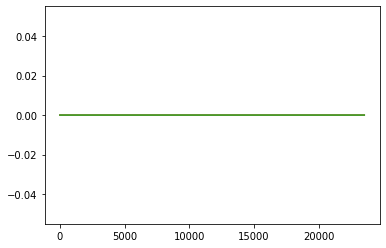

In [227]:
M = 5000
N = M + 200
plt.plot(zr - sr)

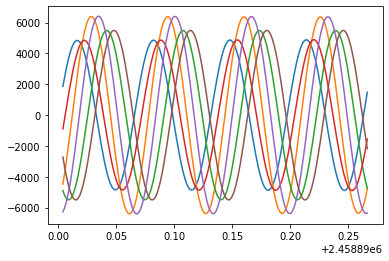

In [228]:
M = 5000
N = M + 200
plt.plot(tz[M:N], xr[M:N], tz[M:N], yr[M:N])

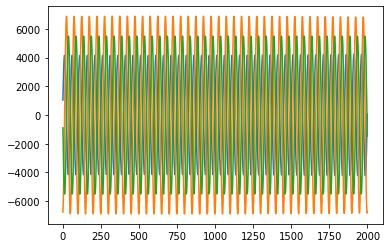

In [229]:
M = 0
N = M + 2000
plt.plot(xr[M:N])

In [230]:
#See https://space.stackexchange.com/questions/1904/how-to-programmatically-calculate-orbital-elements-using-position-velocity-vectors
def get_orb_features(__r, __v):
    #Считаем базисный вектор плоскости орбиты
    _r = __r.copy() * 1000
    _v = __v.copy() * 1000
    #Так удобнее считать
    rt = _r.T.copy()
    rn = np.linalg.norm(rt, axis=0)
    
    vt = _v.T.copy()
    vn = np.linalg.norm(vt, axis=0)
    
    # Специальная механическая энергия
    # E = vn**2/2 - mu/rn
    E = vn*vn*.5 - earth_mu/rn
    a = - earth_mu/2./E
    mm = np.sqrt(earth_mu / (a*a*a)) * 60 #Согласовываем с sgp4
    
    return E, rn, mm

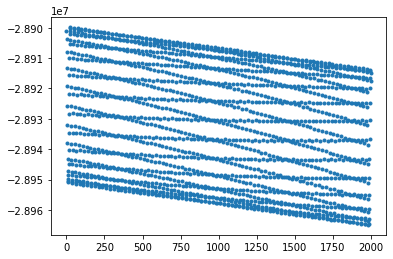

In [231]:
plt.plot(get_orb_features(xr[M:N], xv[M:N])[0], '.')

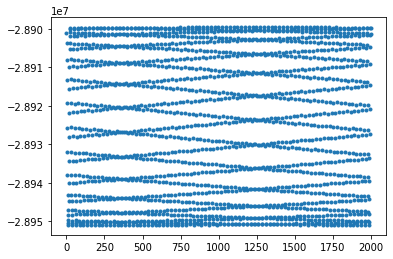

In [232]:
plt.plot(get_orb_features(yr[M:N], yv[M:N])[0], '.')

In [233]:
#Подгонка sgp4 при этом нам изветсна исходная орбита, сгенерированная cgp4
# т.е. на входе у нас xr,xv,jd,fr
r,v,_jd,_fr = xr, xv, jd, fr

mi_search = 20

E, rn, mm = get_orb_features(r, v)


t2 = 4. * np.pi / np.mean(mm) / 1440.
#TODO: Нужно что-то быстрее
times = _jd + _fr
for i,tm in enumerate(times):
    if tm > times[0] + t2:
        break
        
#Номер точки с апогеем
#i = rn[:i].tolist().index(np.max(rn[:i]))# Не уверен насчет сдвига
# Пробуем найти правильное начало эпохи
for i, apo_epoch in enumerate(times):
    tle_b0, j, exc = fit_sgp4_bstar_fixed(r[i], v[i], apo_epoch, max_iter=mi_search)
    if exc == 0 and j < 20:
        print(j)
        l1,l2 = fake_tle(apo_epoch, *estimate_transform(0, 0, 0, *tuple(tle_b0)))
        print(l1)
        print(l2)
        break
        
# Тут мы оределились с эпохой и вычислили 6 элементов орбиты, осталось найти bstar
# Будем использовать частоту, т.к. между частотой и bstar прямая зависимость
def eval_bstar(_bstar, _x, __jd, __fr, _epoch):
    
    tle = fake_tle(_epoch, *estimate_transform(0,0,_bstar,*tuple(_x)))
    zsat = Satrec.twoline2rv(*tle)
    ze,zr,zv = zsat.sgp4_array(__jd, __fr)
    
    if np.sum(ze) > 0:
        #print(ze)
        tle = fake_tle(_epoch, *estimate_transform(0,0,0,*tuple(_x)))
        zsat = Satrec.twoline2rv(*tle)
        ze,zr,zv = zsat.sgp4_array(__jd, __fr)
    
    if np.sum(ze) > 0:
        raise ValueError('Can\'t find valid bstar!')
    
    zE, zrn, zmm = get_orb_features(zr, zv)

    return np.mean(zmm)
    
max_iter = 1000
stop_thr = 1e-10
eps = .7
g = .0000001
bs = 2e-10
y0 = np.mean(mm)
#print(y0)
s = True

for i in range(max_iter):
    e = y0 - eval_bstar(bs, tle_b0, _jd, _fr, apo_epoch)
    
    if abs(e)/y0 < stop_thr:
        break
        
    if (e > 0) ^ s:
        g *= 1 - eps
    else:
        g *= 1 + eps
        
    s = e > 0
    bs += g*e
        
#print(bs)
l1,l2 = fake_tle(apo_epoch, *estimate_transform(0,0,bs,*tuple(tle_b0)))
print(i)
print(l1)
print(l2)
print('\n')

print(xsat.tle1)
print(xsat.tle2)
print('\n')

bsat = Satrec.twoline2rv(l1,l2)
be, br, bv = bsat.sgp4_array(jd, fr)

print(np.unique(be))

19
1 99999U 99999A   20034.91667824  .00000000  00000-0  00000-0 0  9992
2 99999  52.9973  93.0874 0000000 230.3909 318.9391 15.18042836 99997
999
1 99999U 99999A   20034.91667824  .00000000  00000-0  10100-1 0  9995
2 99999  52.9973  93.0874 0000000 230.3909 318.9391 15.18042836 99997


1 44249U 19029Q   20034.91667824  .00214009  00000-0  10093-1 0  9996
2 44249  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020  1798


[0]


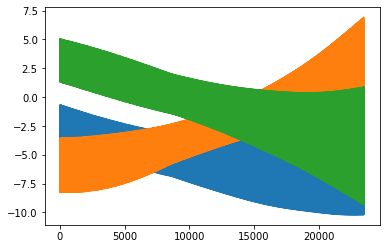

In [234]:
plt.plot(xr - br)

# Ближе к реальности #

К сожалению, приведенный выше код годится только для восстановления TLE из массива данных, сгенерированного моделью sgp4.

Для того, чтобы идентифицировать спутники на данных, сгенерированных более точными моделями, либо на реальных данных нужно приделать к SGP4 оценивающий фильтр.

In [247]:
from progressbar import progressbar as bar
from orbital.constants import earth_radius_mean, earth_radius_equatorial

from pysatrec import PySatrec

TTL  = 31.                              #Требуемое время жизни спутника на орбите в сутках
MAXR = 152000e+3                        #Апогей самой высокой орбиты ("Интеграл")
MINR = earth_radius_equatorial + 50e+3  #Радиус земли + 50 км. (стратосфера)
MAXN = np.sqrt(earth_mu/MINR**3) * 60.
MINN = np.sqrt(earth_mu/MAXR**3) * 60.

TLE_NUM = [0,1,3,6]
TLE_ANG = [2,4,5]


_epoch = 0.

def sp_lim(x, xb):
    global _epoch
    # x: 'bstar', 'inclo', 'nodeo', 'ecco', 'argpo', 'mo', 'no_kozai'

    #Изменение x
    dx = x - xb

    #Апогей
    a = (earth_mu/((x[6]/60)**2))**(1/3)

    # Предел эксцентричитета
    el = max((1. - (MINR/a)), 0.)
    el = min(.9999999, el) #Особенности TLE

    # Ограничения:
    #inclo[0, pi) ecco [0;.el), no_kozai [0; 0.07)
    for i,ul in ((1, np.pi), (3, el), (6, MAXN)):

        if x[i] >= ul:
            dx[i] = (ul - xb[i])/2

        if x[i] < 0:
            dx[i] = -xb[i]/2

    #Коррекция x с учетом ограничений
    x = xb + dx

    #Органичение на bstar
    if x[0] > 0:
        #Чтобы не упасть в перигее нужно считать по "низкой" орбите
        a = (1 - x[3]) * (earth_mu/((x[6]/60)**2))**(1/3) #Теперь тут перигей
        n = (earth_mu/a**3)**0.5 * 60 #Частота для самой низкой орбиты
        s = PySatrec.new_sat(_epoch, 0, 0, 1e-9, x[1], x[2], 1e-8, x[4], x[5], n)
        bl = s.bstar_lima(TTL, MINR)
        if x[0] >= bl:
            x[0] = (xb[0] + bl)*.5
    else:
        s = PySatrec.new_sat(_epoch, 0, 0, 1e-9, *list(x[1:]))
        bl = s.bstar_lima(TTL, MAXR)
        if x[0] <= bl:
            x[0] = (xb[0] + bl)*.5

    #Нормализация углов
    for i in TLE_ANG:
        x[i] = fmod(x[i], 2.*np.pi)
        if x[i] < 0:
            x[i] = 2.*np.pi - x[i]

    return x

def res_sgp4(a,b):
    r = a - b
    #Разница между углами [0,2pi] считается так:
    for i in TLE_ANG:
        if r[i] > np.pi:
            r[i] -= 2*np.pi
        if r[i] < -np.pi:
            r[i] += 2*np.pi
    return r

def mean_sgp4(sigmas, Wm):
    x = np.zeros(7)
    #Синусы и косинусы углов
    si = np.zeros(3)
    co = np.zeros(3)
    for i, s in enumerate(sigmas):
        x[TLE_NUM] += s[TLE_NUM]*Wm[i]
        si += np.sin(s[TLE_ANG])*Wm[i]
        co += np.cos(s[TLE_ANG])*Wm[i]
    #Считаем "средние" углы
    ang = np.arctan2(si, co)
    #Нормализуем средние углы
    for i in range(3):
        if ang[i] < 0.:
            ang[i] += 2*np.pi
    #Пишем углы
    x[TLE_ANG] = ang
    #Готово
    return x

def res_pe(a,b):
    s = b
    rn = np.linalg.norm(s[:3])
    vn = np.linalg.norm(s[3:])
    d = a - b
    d[:3] /= rn
    d[3:] /= vn
    return d

class SigmaWrapperSGP4(object):
    
    def __init__(self, points):
        self.points = points
        
    def num_sigmas(self):
        return self.points.num_sigmas()
    
    def sigma_points(self, x, P):
        #Считаем сигма-точки
        p = self.points.sigma_points(x, P)
        
        #Ограничивам сигма-точки
        for i in range(len(p)):
            p[i] = sp_lim(p[i], x)
        
        #print(p)
        return p
    
    @property
    def Wm(self):
        return self.points.Wm
    
    @property
    def Wc(self):
        return self.points.Wc

# fx/hx args: xbase, xbase_z, epoch, current
def sgp4_fx(x, dt, **fx_args):
    return x

def sgp4_hx(x, **hx_args):

    #Конструируем спутник
    hsat = PySatrec.new_sat(hx_args['epoch'], 0, 0, *list(x))
    #tle = fake_tle(hx_args['epoch'], *estimate_transform(0, 0, *tuple(x)))
    #hsat = Satrec.twoline2rv(*tle)
    
    #Моделируем текущее состояние по предыдущему
    hfr, hjd = np.modf(hx_args['current'])
    he,hr,hv = hsat.sgp4(hjd, hfr)
    
    if he > 0:
        print('x:',x)
        raise ValueError('Can\'t observe the sat state! Error:%d' % he)
    
    return np.array(list(hr) + list(hv))
    
#Задаем условия задачи
r,v,_jd,_fr = xr, xv, jd, fr
z = np.concatenate((r,v), axis=1)

#Setup the Kalman filter
dt = tz[1] - tz[0]
DIMX = 7

#Задаем равным машинным эпсилонам для отдельных величин
aeps = .5e-4 * d2r
#                    'bstar', 'inclo', 'nodeo', 'ecco',    'argpo', 'mo', 'no_kozai'
x_std = np.array([.000005e-9,    aeps,    aeps,  .5e-7,       aeps, aeps, .5e-8*xd2rm])

DIMZ = 6
z_std = .00001
    
_epoch = tz[0]
points = SigmaWrapperSGP4(MerweScaledSigmaPoints(DIMX, alpha=.1, beta=2., kappa=3-DIMX))

kf = None
ii = list(range(len(tz)-1))
for m in (.1, .01, .001, .0001, .00001, .000001, .0000001, .00000001):
    try:
        kf = UnscentedKalmanFilter(dim_x=DIMX, dim_z=DIMZ, dt=dt, fx=sgp4_fx, hx=sgp4_hx, 
                           points=points, residual_x=res_sgp4, x_mean_fn=mean_sgp4, residual_z=res_pe)
        kf.x = np.array([0.0]*DIMX)
        kf.x[1:] = get_tle_data(r[0], v[0])
        kf.Q = np.diag(x_std*x_std) # 1 standard
        kf.R = np.diag([z_std**2]*DIMZ) # 1 standard
        kf.P *= m
        y = []
        for i in bar(ii):
            kf.predict()
            kf.update(z[i+1], epoch=tz[0], current=tz[i+1])
            y.append(np.linalg.norm(kf.y))
        break
    except Exception as e:
        print(m)
        print(e)

100% (23529 of 23529) |##################| Elapsed Time: 0:04:12 Time:  0:04:12


In [248]:
#Конструируем спутник
l1,l2 = fake_tle(tz[0], *estimate_transform(0, 0, 0, *tuple(get_tle_data(r[0], v[0]))))
print(l1)
print(l2)
print('\n')

l1,l2 = fake_tle(tz[0], *estimate_transform(0, 0, *tuple(kf.x)))
print(l1)
print(l2)
print('\n')

print(xsat.tle1)
print(xsat.tle2)
print('\n')

#Моделируем текущее состояние по предыдущему
ksat = Satrec.twoline2rv(l1,l2)
ke,kr,kv = ksat.sgp4_array(jd, fr)
print(np.unique(ke))

1 99999U 99999A   20034.91667824  .00000000  00000-0  00000-0 0  9992
2 99999  53.0154  93.0951 0003143 123.8890  65.4487 15.16037134 99995


1 99999U 99999A   20034.91667824  .00000000  00000-0  10687-1 0  9995
2 99999  52.9973  93.0591 0005144   1.2426 190.8646 15.17619731 99999


1 44249U 19029Q   20034.91667824  .00214009  00000-0  10093-1 0  9996
2 44249  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020  1798


[0]


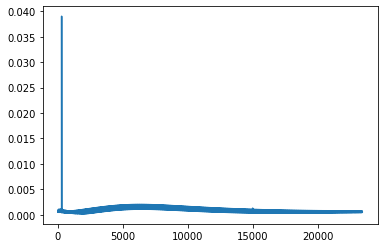

In [249]:
plt.plot(y[100:])

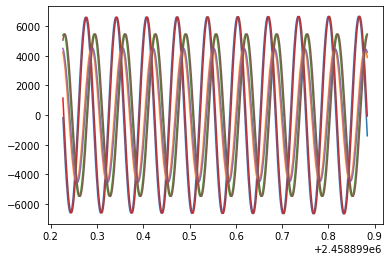

In [250]:
M = 12000
N = M + 500
plt.plot(tz[M:N], xr[M:N], tz[M:N], kr[M:N])

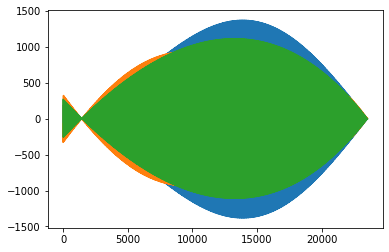

In [251]:
plt.plot(xr-kr)

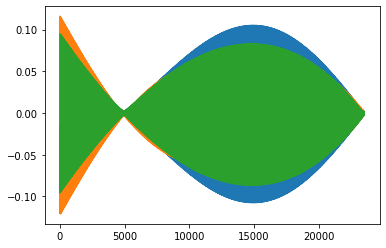

In [246]:
plt.plot(xv - kv)

Это, конечно, не 0.00xx километра, ноу уже кое-что.

In [36]:
print(i)

0
